# Imports

In [1]:
!pip install pytabkit    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 8.5 MB/s eta 0:00:00


In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pytabkit import RealMLP_TD_Classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')

# Global Configuration

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42
N_FOLDS = 5

print(f"Using device: {DEVICE}")

Using device: cuda


# Data Loading and Preprocessing

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
original = pd.read_csv("/kaggle/input/heartdisease/Heart_Disease_Prediction.csv") 

le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease'])
original['Heart Disease'] = le.fit_transform(original['Heart Disease'])

base_features = [col for col in train.columns if col not in ['Heart Disease', 'id']] 

def add_engineered_features(df):
    df_temp = df.copy()
    
    for col in base_features: 
        if col in original.columns:
           
            stats = original.groupby(col)['Heart Disease'].agg(['mean', 'median', 'std', 'skew', 'count']).reset_index()
         
            stats.columns = [col] + [f"orig_{col}_{s}" for s in ['mean', 'median', 'std', 'skew', 'count']]
     
            df_temp = df_temp.merge(stats, on=col, how='left') 
 
            fill_values = {
                f"orig_{col}_mean": original['Heart Disease'].mean(),
                f"orig_{col}_median": original['Heart Disease'].median(),
                f"orig_{col}_std": 0,
                f"orig_{col}_skew": 0,
                f"orig_{col}_count": 0
            }
            df_temp = df_temp.fillna(value=fill_values)
            
    return df_temp

train = add_engineered_features(train)
test = add_engineered_features(test) 

X = train.drop(['id', 'Heart Disease'], axis=1)
y = train['Heart Disease']
X_test = test.drop(['id'], axis=1)

# Data Quality Check (Missing & Duplicates)

In [5]:
def check_data_quality(df, name="Dataset"):
    print(f"--- Data Quality: {name} ---")
    print(f"Total Rows: {len(df)}")

    cols_to_check = [c for c in df.columns if c != 'id']
    dupes = df.duplicated(subset=cols_to_check).sum()

    nan_counts = df.isnull().sum()
    total_nans = nan_counts.sum()
    
    print(f"Duplicate Rows (excl. ID): {dupes}")
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("\nColumns with NaNs:")
        print(nan_counts[nan_counts > 0])
    print("-" * 30)

check_data_quality(train, "Train")
check_data_quality(test, "Test")

--- Data Quality: Train ---
Total Rows: 630000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------
--- Data Quality: Test ---
Total Rows: 270000
Duplicate Rows (excl. ID): 0
Total NaN values: 0
------------------------------


# Feature Uniqueness & Cardinality

In [6]:
def analyze_uniqueness(df):
    unique_stats = []
    for col in df.columns:
        if col == 'id': continue
        
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        category_guess = "Categorical/Ordinal" if n_unique < 25 else "Continuous"
        
        unique_stats.append({
            'Feature': col,
            'Unique Values': n_unique,
            'Data Type': dtype,
            'Heuristic Type': category_guess
        })
    
    return pd.DataFrame(unique_stats).sort_values(by='Unique Values')

uniqueness_df = analyze_uniqueness(train)
print(uniqueness_df)

                     Feature  Unique Values Data Type       Heuristic Type
40  orig_FBS over 120_median              1   float64  Categorical/Ordinal
1                        Sex              2     int64  Categorical/Ordinal
13             Heart Disease              2     int64  Categorical/Ordinal
5               FBS over 120              2     int64  Categorical/Ordinal
20           orig_Sex_median              2   float64  Categorical/Ordinal
..                       ...            ...       ...                  ...
0                        Age             42     int64           Continuous
3                         BP             66     int64           Continuous
9              ST depression             66   float64           Continuous
7                     Max HR             93     int64           Continuous
4                Cholesterol            150     int64           Continuous

[79 rows x 4 columns]


# Visualize Top Skewed Features

Top 6 Most Skewed Features (Absolute Values):
orig_EKG results_count   -15.613416
orig_EKG results_std       6.747575
orig_Slope of ST_count    -5.657311
orig_Thallium_std          4.472673
orig_BP_std               -4.174508
orig_Age_std              -3.145546
dtype: float64


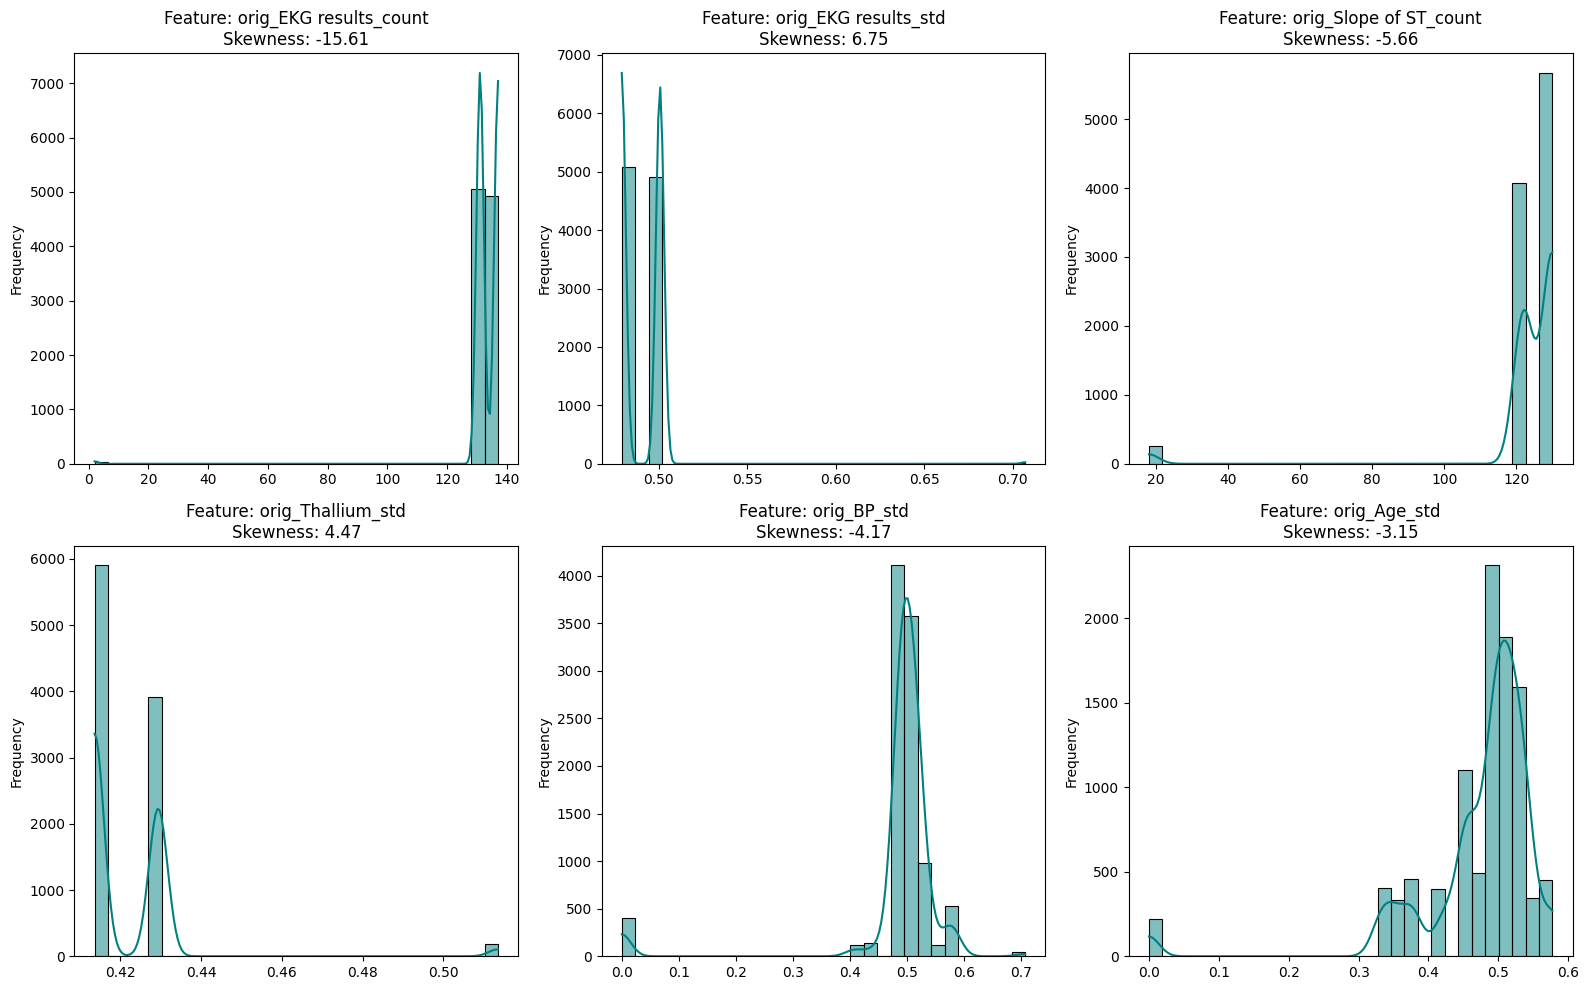

In [7]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

skew_series = X[numeric_cols].skew().abs().sort_values(ascending=False)
top_skewed_features = skew_series.head(6).index.tolist()

print("Top 6 Most Skewed Features (Absolute Values):")
print(X[top_skewed_features].skew())

plt.figure(figsize=(16, 10))
for i, col in enumerate(top_skewed_features):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(X[col].sample(min(10000, len(X))), kde=True, color='teal', bins=30)
    plt.title(f"Feature: {col}\nSkewness: {X[col].skew():.2f}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig('skewed_distributions.png')

In [8]:
# --- Medical Feature Engineering based on NEJM Paper Insights ---
# Paper: "Global Effect of Cardiovascular Risk Factors on Lifetime Estimates"
# Key insights:
# 1. Presence of 5 classic risk factors (Hypertension, Hyperlipidemia, Diabetes, Smoking, Obesity) drastically reduces life-years.
# 2. Modifying hypertension/risk factors at age 55-60 yields the highest benefit.
# 3. Risk profiles differ significantly by Sex (Men have higher baseline risk).

def add_medical_paper_features(df):
    df_eng = df.copy()

    # --- 1. Define Binary Risk Factors (Thresholds) ---
    # Although the dataset lacks Smoking/Obesity, we use the available clinical markers.
    # Hypertension: BP >= 140 is a standard medical threshold for high risk.
    df_eng['Risk_High_BP'] = (df_eng['BP'] >= 140).astype(int)

    # Hyperlipidemia: Cholesterol >= 240 is considered high risk.
    df_eng['Risk_High_Chol'] = (df_eng['Cholesterol'] >= 240).astype(int)

    # Diabetes: Already present as 'FBS over 120'
    df_eng['Risk_Diabetes'] = df_eng['FBS over 120']

    # --- 2. Cumulative Risk Burden ---
    # The paper notes "presence of all five risk factors" vs "none".
    # We sum our available factors to create a 'Risk Burden Score' (0 to 3).
    df_eng['Risk_Burden_Score'] = (
        df_eng['Risk_High_BP'] +
        df_eng['Risk_High_Chol'] +
        df_eng['Risk_Diabetes']
    )

    # --- 3. Critical Age Window (55-60) ---
    # Insight: "Modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years."
    # We flag this specific age window.
    df_eng['Age_Window_55_60'] = ((df_eng['Age'] >= 55) & (df_eng['Age'] < 60)).astype(int)

    # Interaction: Having High BP specifically during this critical window is a strong negative signal.
    df_eng['Critical_Age_Hypertension'] = df_eng['Age_Window_55_60'] * df_eng['Risk_High_BP']

    # --- 4. Midlife Risk Baseline (Age 50) ---
    # Insight: "Absence of risk factors at 50 years of age was associated with... greater life expectancy."
    # We establish a baseline flag for being 50 or older.
    df_eng['Age_50_Plus'] = (df_eng['Age'] >= 50).astype(int)

    # Interaction: Impact of risk burden for those over 50.
    df_eng['Age50_Risk_Interaction'] = df_eng['Age_50_Plus'] * df_eng['Risk_Burden_Score']

    # --- 5. Gender-Specific Risk Interaction ---
    # Insight: "Lifetime risk... was 24% among women and 38% among men."
    # Male sex implies a higher baseline risk slope for the same number of risk factors.
    # We capture this by interacting Sex with the Risk Score.
    df_eng['Sex_Risk_Interaction'] = df_eng['Sex'] * df_eng['Risk_Burden_Score']

    return df_eng

# Apply the engineering to both Train and Test sets
X = add_medical_paper_features(X)
X_test = add_medical_paper_features(X_test)

# --- Important: Define New Features as Categorical ---
# Since these are binary flags or small integer counts, they work best with Entity Embedding (Category) in RealMLP.
new_medical_features = [
    'Risk_High_BP', 'Risk_High_Chol', 'Risk_Diabetes', 'Risk_Burden_Score',
    'Age_Window_55_60', 'Critical_Age_Hypertension',
    'Age_50_Plus', 'Age50_Risk_Interaction', 'Sex_Risk_Interaction'
]

# Ensure they are treated as categorical strings for the model
for col in new_medical_features:
    X[col] = X[col].astype(str).astype('category')
    X_test[col] = X_test[col].astype(str).astype('category')

print(f"Added {len(new_medical_features)} new medical features based on NEJM paper insights.")
print(X[new_medical_features].head())

Added 9 new medical features based on NEJM paper insights.
  Risk_High_BP Risk_High_Chol Risk_Diabetes Risk_Burden_Score  \
0            1              0             0                 1   
1            0              1             0                 1   
2            1              0             0                 1   
3            0              0             0                 0   
4            1              0             0                 1   

  Age_Window_55_60 Critical_Age_Hypertension Age_50_Plus  \
0                1                         1           1   
1                0                         0           1   
2                1                         1           1   
3                0                         0           0   
4                1                         1           1   

  Age50_Risk_Interaction Sex_Risk_Interaction  
0                      1                    1  
1                      1                    1  
2                      1                    0

In [9]:
# --- Cell 1: 为两个模型准备各自喜欢的数据格式 ---

# 1. 基础特征列表
# 这些是核心数值特征，CatBoost 喜欢原样，RealMLP 喜欢转成 Category
num_cols_base = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']
# 把你生成的 orig_ 统计特征也算作数值
num_cols = num_cols_base + [c for c in X.columns if c.startswith('orig_')]

# 剩下的就是类别特征 (包括 Sex, Chest Pain, 以及你刚才加的 Risk_High_BP 等)
cat_cols = [c for c in X.columns if c not in num_cols]

# ==========================================
# 数据集 A: 给 RealMLP (全员 Category)
# ==========================================
X_mlp = X.copy()
X_test_mlp = X_test.copy()

# RealMLP 策略：不管三七二十一，全部转字符串
for col in X_mlp.columns:
    X_mlp[col] = X_mlp[col].astype(str).astype('category')
    X_test_mlp[col] = X_test_mlp[col].astype(str).astype('category')

# ==========================================
# 数据集 B: 给 CatBoost (数值保留，类别转 Category)
# ==========================================
X_cb = X.copy()
X_test_cb = X_test.copy()

# CatBoost 策略：数值不动，类别转 Category
for col in cat_cols:
    X_cb[col] = X_cb[col].astype(str).astype('category')
    X_test_cb[col] = X_test_cb[col].astype(str).astype('category')

print(f"数据准备完毕!")
print(f"RealMLP 输入: 全量 Category ({X_mlp.shape[1]} cols)")
print(f"CatBoost 输入: {len(num_cols)} 数值 + {len(cat_cols)} 类别")

数据准备完毕!
RealMLP 输入: 全量 Category (87 cols)
CatBoost 输入: 71 数值 + 16 类别


# Cross-Validation & Training

In [10]:
# --- Cell 2: RealMLP + CatBoost 双模型训练 ---
from catboost import CatBoostClassifier

param_grid = {
        'device': 'cuda',
        'random_state': 42,
        'verbosity': 2,
        'n_epochs': 100,
        'batch_size': 256, 
        'n_ens': 8, 
        'use_early_stopping': True,
        'early_stopping_additive_patience': 20,
        'early_stopping_multiplicative_patience': 1,
        'act': "mish",
        'embedding_size': 8,
        'first_layer_lr_factor': 0.5962121993798933,
        'hidden_sizes': "rectangular",
        'hidden_width': 384,
        'lr': 0.04, 
        'ls_eps': 0.011498317194338772,
        'ls_eps_sched': "coslog4",
        'max_one_hot_cat_size': 18,
        'n_hidden_layers': 4, 
        'p_drop': 0.07301419697186451,
        'p_drop_sched': "flat_cos",
        'plr_hidden_1': 16, 
        'plr_hidden_2': 8,
        'plr_lr_factor': 0.1151437622270563,
        'plr_sigma': 2.3316811282666916,
        'scale_lr_factor': 2.244801835541429,
        'sq_mom': 1.0 - 0.011834054955582318,
        'wd': 0.02369230879235962,
    } 

# 🎛️ 融合权重控制 (0.0 - 1.0)
MLP_WEIGHT = 0.5

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Starting Fold {fold + 1} ---")

    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # ==========================
    # 模型 1: RealMLP (用 X_mlp)
    # ==========================
    # 取出全 Category 数据
    X_tr_mlp, X_val_mlp = X_mlp.iloc[train_idx], X_mlp.iloc[val_idx]
    
    model_mlp = RealMLP_TD_Classifier(**param_grid)
    model_mlp.fit(X_tr_mlp, y_tr.values, X_val_mlp, y_val.values)
    
    # 预测概率
    p_val_mlp = model_mlp.predict_proba(X_val_mlp)[:, 1]
    p_test_mlp = model_mlp.predict_proba(X_test_mlp)[:, 1]

    # ==========================
    # 模型 2: CatBoost (用 X_cb)
    # ==========================
    # 取出混合类型数据
    X_tr_cb, X_val_cb = X_cb.iloc[train_idx], X_cb.iloc[val_idx]

    model_cb = CatBoostClassifier(
        iterations=3000,           # 树的数量
        learning_rate=0.02,        # 学习率
        depth=6,                   # 深度
        eval_metric='AUC',
        cat_features=cat_cols,     # 明确指定类别列
        verbose=0,
        random_state=RANDOM_STATE,
        allow_writing_files=False
    )

    model_cb.fit(X_tr_cb, y_tr, eval_set=(X_val_cb, y_val), early_stopping_rounds=100, verbose=0)
    
    p_val_cb = model_cb.predict_proba(X_val_cb)[:, 1]
    p_test_cb = model_cb.predict_proba(X_test_cb)[:, 1]

    # ==========================
    # ⚖️ 融合 (Weighted Ensemble)
    # ==========================
    val_probs = MLP_WEIGHT * p_val_mlp + (1 - MLP_WEIGHT) * p_val_cb
    fold_test_probs = MLP_WEIGHT * p_test_mlp + (1 - MLP_WEIGHT) * p_test_cb

    # 记录结果
    oof_preds[val_idx] = val_probs
    test_preds += fold_test_probs / N_FOLDS

    score = roc_auc_score(y_val, val_probs)
    fold_scores.append(score)
    
    print(f"Fold {fold+1} Final AUC: {score:.5f}")
    print(f"   >> RealMLP AUC:  {roc_auc_score(y_val, p_val_mlp):.5f}")
    print(f"   >> CatBoost AUC: {roc_auc_score(y_val, p_val_cb):.5f}")

    if DEVICE == 'cuda':
        torch.cuda.empty_cache()

print(f"\n整体 CV Score: {np.mean(fold_scores):.5f}")


--- Starting Fold 1 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 'orig_FBS over 120_count', 'orig_EKG results_mean', 'orig_EKG results_median', 'or

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.110325
Epoch 2/100: val class_error = 0.110032
Epoch 3/100: val class_error = 0.110611
Epoch 4/100: val class_error = 0.110452
Epoch 5/100: val class_error = 0.109802
Epoch 6/100: val class_error = 0.108984
Epoch 7/100: val class_error = 0.108937
Epoch 8/100: val class_error = 0.109667
Epoch 9/100: val class_error = 0.109389
Epoch 10/100: val class_error = 0.109405
Epoch 11/100: val class_error = 0.109881
Epoch 12/100: val class_error = 0.109484
Epoch 13/100: val class_error = 0.109913
Epoch 14/100: val class_error = 0.109548
Epoch 15/100: val class_error = 0.109913
Epoch 16/100: val class_error = 0.109524
Epoch 17/100: val class_error = 0.109524
Epoch 18/100: val class_error = 0.109087
Epoch 19/100: val class_error = 0.109159
Epoch 20/100: val class_error = 0.109286
Epoch 21/100: val class_error = 0.109278
Epoch 22/100: val class_error = 0.109262
Epoch 23/100: val class_error = 0.109206
Epoch 24/100: val class_error = 0.109730
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 1 Final AUC: 0.95605
   >> RealMLP AUC:  0.95609
   >> CatBoost AUC: 0.95587

--- Starting Fold 2 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.112246
Epoch 2/100: val class_error = 0.112333
Epoch 3/100: val class_error = 0.111976
Epoch 4/100: val class_error = 0.112079
Epoch 5/100: val class_error = 0.111778
Epoch 6/100: val class_error = 0.111849
Epoch 7/100: val class_error = 0.111984
Epoch 8/100: val class_error = 0.111810
Epoch 9/100: val class_error = 0.112286
Epoch 10/100: val class_error = 0.111730
Epoch 11/100: val class_error = 0.111913
Epoch 12/100: val class_error = 0.112516
Epoch 13/100: val class_error = 0.112238
Epoch 14/100: val class_error = 0.112452
Epoch 15/100: val class_error = 0.112444
Epoch 16/100: val class_error = 0.112214
Epoch 17/100: val class_error = 0.111794
Epoch 18/100: val class_error = 0.112071
Epoch 19/100: val class_error = 0.112040
Epoch 20/100: val class_error = 0.112183
Epoch 21/100: val class_error = 0.111873
Epoch 22/100: val class_error = 0.112302
Epoch 23/100: val class_error = 0.111960
Epoch 24/100: val class_error = 0.112032
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 2 Final AUC: 0.95494
   >> RealMLP AUC:  0.95488
   >> CatBoost AUC: 0.95481

--- Starting Fold 3 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111476
Epoch 2/100: val class_error = 0.111190
Epoch 3/100: val class_error = 0.110770
Epoch 4/100: val class_error = 0.111008
Epoch 5/100: val class_error = 0.111286
Epoch 6/100: val class_error = 0.110563
Epoch 7/100: val class_error = 0.111024
Epoch 8/100: val class_error = 0.110929
Epoch 9/100: val class_error = 0.110794
Epoch 10/100: val class_error = 0.111119
Epoch 11/100: val class_error = 0.111254
Epoch 12/100: val class_error = 0.111302
Epoch 13/100: val class_error = 0.110730
Epoch 14/100: val class_error = 0.110929
Epoch 15/100: val class_error = 0.111008
Epoch 16/100: val class_error = 0.110937
Epoch 17/100: val class_error = 0.110841
Epoch 18/100: val class_error = 0.110627
Epoch 19/100: val class_error = 0.110802
Epoch 20/100: val class_error = 0.110873
Epoch 21/100: val class_error = 0.110667
Epoch 22/100: val class_error = 0.110794
Epoch 23/100: val class_error = 0.110833
Epoch 24/100: val class_error = 0.111135
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 3 Final AUC: 0.95579
   >> RealMLP AUC:  0.95581
   >> CatBoost AUC: 0.95564

--- Starting Fold 4 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111952
Epoch 2/100: val class_error = 0.111556
Epoch 3/100: val class_error = 0.111746
Epoch 4/100: val class_error = 0.111762
Epoch 5/100: val class_error = 0.111437
Epoch 6/100: val class_error = 0.111389
Epoch 7/100: val class_error = 0.111317
Epoch 8/100: val class_error = 0.111246
Epoch 9/100: val class_error = 0.111524
Epoch 10/100: val class_error = 0.111405
Epoch 11/100: val class_error = 0.111786
Epoch 12/100: val class_error = 0.111651
Epoch 13/100: val class_error = 0.111579
Epoch 14/100: val class_error = 0.111802
Epoch 15/100: val class_error = 0.111587
Epoch 16/100: val class_error = 0.111540
Epoch 17/100: val class_error = 0.111381
Epoch 18/100: val class_error = 0.111238
Epoch 19/100: val class_error = 0.111230
Epoch 20/100: val class_error = 0.111310
Epoch 21/100: val class_error = 0.111254
Epoch 22/100: val class_error = 0.111333
Epoch 23/100: val class_error = 0.111254
Epoch 24/100: val class_error = 0.111484
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 4 Final AUC: 0.95546
   >> RealMLP AUC:  0.95547
   >> CatBoost AUC: 0.95529

--- Starting Fold 5 ---
Columns classified as continuous: []
Columns classified as categorical: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'orig_Age_mean', 'orig_Age_median', 'orig_Age_std', 'orig_Age_skew', 'orig_Age_count', 'orig_Sex_mean', 'orig_Sex_median', 'orig_Sex_std', 'orig_Sex_skew', 'orig_Sex_count', 'orig_Chest pain type_mean', 'orig_Chest pain type_median', 'orig_Chest pain type_std', 'orig_Chest pain type_skew', 'orig_Chest pain type_count', 'orig_BP_mean', 'orig_BP_median', 'orig_BP_std', 'orig_BP_skew', 'orig_BP_count', 'orig_Cholesterol_mean', 'orig_Cholesterol_median', 'orig_Cholesterol_std', 'orig_Cholesterol_skew', 'orig_Cholesterol_count', 'orig_FBS over 120_mean', 'orig_FBS over 120_median', 'orig_FBS over 120_std', 'orig_FBS over 120_skew', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/100: val class_error = 0.111452
Epoch 2/100: val class_error = 0.110889
Epoch 3/100: val class_error = 0.112365
Epoch 4/100: val class_error = 0.111159
Epoch 5/100: val class_error = 0.110563
Epoch 6/100: val class_error = 0.110468
Epoch 7/100: val class_error = 0.110333
Epoch 8/100: val class_error = 0.110810
Epoch 9/100: val class_error = 0.110762
Epoch 10/100: val class_error = 0.110921
Epoch 11/100: val class_error = 0.111437
Epoch 12/100: val class_error = 0.111230
Epoch 13/100: val class_error = 0.110579
Epoch 14/100: val class_error = 0.110413
Epoch 15/100: val class_error = 0.110571
Epoch 16/100: val class_error = 0.110611
Epoch 17/100: val class_error = 0.110476
Epoch 18/100: val class_error = 0.110532
Epoch 19/100: val class_error = 0.110563
Epoch 20/100: val class_error = 0.110714
Epoch 21/100: val class_error = 0.110611
Epoch 22/100: val class_error = 0.110595
Epoch 23/100: val class_error = 0.110460
Epoch 24/100: val class_error = 0.110389
Epoch 25/100: val class_e

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Fold 5 Final AUC: 0.95622
   >> RealMLP AUC:  0.95625
   >> CatBoost AUC: 0.95605

整体 CV Score: 0.95569


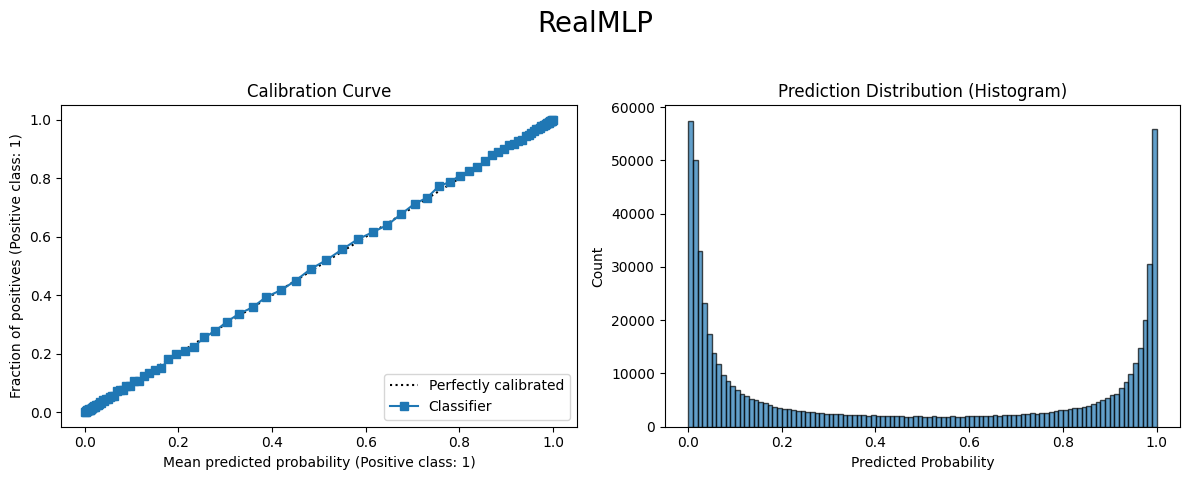

In [11]:
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(12, 5)) 
plt.suptitle('RealMLP', fontsize=20) 

ax1 = plt.subplot(1, 2, 1)
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=100, strategy='quantile', ax=ax1)
ax1.set_title('Calibration Curve')

ax2 = plt.subplot(1, 2, 2)
ax2.hist(oof_preds, bins=100, edgecolor='black', alpha=0.7)
ax2.set_title('Prediction Distribution (Histogram)')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Evaluation and Submission

In [12]:
total_oof_score = roc_auc_score(y, oof_preds) 

print("\n" + "="*40)
print(f"Overall OOF ROC-AUC: {total_oof_score:.5f}")
print(f"Mean Fold Score: {np.mean(fold_scores):.5f} (+/- {np.std(fold_scores):.5f})")
print("="*40)

pd.DataFrame({'id': train['id'], 'Heart Disease_prob': oof_preds}).to_csv('oof.csv', index=False)

submission = pd.DataFrame({'id': test['id'], 'Heart Disease': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head() 


Overall OOF ROC-AUC: 0.95566
Mean Fold Score: 0.95569 (+/- 0.00046)


,id,Heart Disease
0,630000,0.949352
1,630001,0.008699
2,630002,0.989645
3,630003,0.005438
4,630004,0.210480


# Baseline 
现在考虑了original的特征并加入了train作为了特征量
使用了frequency版的mlp

# Version3
增加9个医学特征量

1. "Five risk factors account for approximately 50% of the global burden of cardiovascular disease. How the presence or absence of classic risk factors affects lifetime estimates of cardiovascular disease and death from any cause remains unclear."

"Lifetime risk of cardiovascular disease and death from any cause was estimated up to 90 years of age according to the presence or absence of arterial hypertension, hyperlipidemia, underweight and overweight or obesity, diabetes, and smoking at 50 years of age. Differences in life span (in terms of additional life-years free of cardiovascular disease or death from any cause) according to the presence or absence of these risk factors were also estimated."

"The lifetime risk of cardiovascular disease was 24% (95% confidence interval [CI], 21 to 30) among women and 38% (95% CI, 30 to 45) among men for whom all five risk factors were present. In the comparison between participants with none of the risk factors and those with all the risk factors, the estimated number of additional life-years free of cardiovascular disease was 13.3 (95% CI, 11.2 to 15.7) for women and 10.6 (95% CI, 9.2 to 12.9) for men; the estimated number of additional life-years free of death was 14.5 (95% CI, 9.1 to 15.3) for women and 11.8 (95% CI, 10.1 to 13.6) for men. As compared with no changes in the presence of all risk factors, modification of hypertension at an age of 55 to less than 60 years was associated with the most additional life-years free of cardiovascular disease, and modification of smoking at an age of 55 to less than 60 years was associated with the most additional life-years free of death."

"The absence of five classic risk factors at 50 years of age was associated with more than a decade greater life expectancy than the presence of all five risk factors, in both sexes. Persons who modified hypertension and smoking in midlife had the most additional life-years free of cardiovascular disease and death from any cause, respectively." 基于这个考虑扩张特征量

2. 用lgbm+mlp的混合模型
3. 现在age,BP, Cholesterol都label embedding了，再考虑一下是不是应该保留数值呢
4. 混合模型时考虑核心 trick：裁判模型不仅看 MLP 和 CatBoost 的预测值，还看原始数据的特征（Age, Sex...）。

原理：有时候，MLP 在某些特定年龄段（比如 60-70 岁）特别准，而 CatBoost 在年轻人中特别准。如果把原始特征（Age）也喂给裁判模型，裁判就能学会：“哦，这是一个 65 岁的病人，那我要多听 MLP 的意见；如果是个年轻人，我就听 CatBoost 的。”

Broccoli Beef 的代码演示了用 StackingClassifier(..., passthrough=True) 实现了这一点，并获得了分数的微弱提升。
 
